In [1]:
# library imports
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import sys
from tqdm import trange, tqdm

# importing our helper functions
from helper import *

# Config
from config import * # we standardise config across all files
'''
NUM_CUSTOMERS = 50
NUM_CHARGERS = 30
NUM_VEHICLES = 10
BATTERY_CAPACITY = 10
ENERGY_PER_KM = 0.187
TIME_PER_KM = 3 # in minutes
TOTAL_TIME_ALLOWED = 600
'''

# hello()

'\nNUM_CUSTOMERS = 50\nNUM_CHARGERS = 30\nNUM_VEHICLES = 10\nBATTERY_CAPACITY = 10\nENERGY_PER_KM = 0.187\nTIME_PER_KM = 3 # in minutes\nTOTAL_TIME_ALLOWED = 600\n'

In [2]:
random.seed(5)

# Electric Vehicle Points
ev_pts = pd.read_csv("Unique_EV_Points.csv")
charge_pts = ev_pts.sample(n=NUM_CHARGERS)[['Longitude', 'Latitude']] # dataframe
charge_pts_list = list(charge_pts.itertuples(index=False, name=None)) # list

# Delivery locations Points
dl = pd.read_csv("DeliveryLocations.csv")
todays_locations = dl.sample(n=NUM_CUSTOMERS)
dl_list = list(todays_locations.itertuples(index=False, name=None))

# Fedex Ship Centre
fedex_centre = [(104.0023106, 1.3731437)]

locations = fedex_centre + dl_list + charge_pts_list # combined list of all locations
print(locations)

[(104.0023106, 1.3731437), (103.8462315, 1.371096498), (103.8540434, 1.364946014), (103.7515776, 1.40162672), (103.9051119, 1.386690883), (103.962797, 1.373368723), (103.8333464, 1.414540772), (103.7927914, 1.440991295), (103.9026191, 1.40157247), (103.7474537, 1.340960547), (103.8919927, 1.38485976), (103.8245363, 1.282218691), (103.7201844, 1.339365794), (103.828909, 1.428866921), (103.7507505, 1.361412265), (103.8755513, 1.316855329), (103.7094114, 1.34809658), (103.7415732, 1.341067511), (103.7708221, 1.387291051), (103.9513156, 1.344585551), (103.9355097, 1.328830662), (103.9108807, 1.398752034), (103.8252028, 1.28209884), (103.874486, 1.39354732), (103.8702122, 1.34964854), (103.8386063, 1.435309736), (103.8272396, 1.274397181), (103.8442143, 1.337816161), (103.8416736, 1.435530626), (103.8002822, 1.447512124), (103.8465743, 1.426349826), (103.8875087, 1.33018852), (103.8811043, 1.39677177), (103.8446752, 1.422053752), (103.8259329, 1.274528526), (103.7494473, 1.361014444), (103.

## Calculate the distance, time and energy between locations

In [3]:
# Total nodes: 1 depot + customers + chargers
n = len(locations)
customer_nodes = list(range(1, 1 + NUM_CUSTOMERS)) # gets the index/nodes of customers
charger_nodes = list(range(1 + NUM_CUSTOMERS, n))  

# Compute Distance & Energy Matrices
distance_matrix = np.zeros((n, n))
time_matrix = np.zeros((n, n))
energy_matrix = np.zeros((n, n))

def calc_dist(p1, p2):
    """
    Calculates the straight-line (euclidean) distance
    """
    lon_diff = p1[0] - p2[0]
    lat_diff = p1[1] - p2[1]
    return 111 * np.sqrt(lon_diff**2 + lat_diff**2)

for i in range(n):
    for j in range(n):
        if i != j:
            dist = calc_dist(locations[i], locations[j])
            distance_matrix[i][j] = dist
            energy_matrix[i][j] = dist * ENERGY_PER_KM
            time_matrix[i][j] = dist * TIME_PER_KM

def total_distance(routes, locations):
    """
    Returns total distance of for all route in routes
    """
    dist = 0.0
    for route in routes:
        for i in range(len(route) - 1):
            dist += calc_dist(locations[route[i]], locations[route[i+1]])
    return dist

def num_activated_vehicles(routes):
    """
    Calculates number of activated vehicles
    """
    return len(routes) - sum(1 for route in routes if route == [0, 0])

In [4]:
random.seed(5)
# Helper Functions
def calculate_route_violations(route, locations): # to be optimised
    """
    Calculates battery and time violations for a single route
    Returns:
        - battery_violation: total amout of energy deficit across all segments
        - time_violation: amount of time exceeded beyond given limit
    tuple of (battery_violation, time_violation)
    """
    battery = BATTERY_CAPACITY
    battery_violation = 0
    total_time_taken = 0
    time_violation = 0
    
    if len(route) <= 2: #empty route of [0,0]
        return 0,0

    for i in range(len(route) - 1):
        prev_node = route[i]
        curr_node = route[i+1]
        
        # Add travel time
        total_time_taken += time_matrix[prev_node][curr_node]
        
        # Energy required for this segment
        energy_needed = energy_matrix[prev_node][curr_node]

        if energy_needed > battery:
            # This segment is infeasible from the current state
            battery_violation += (energy_needed - battery)
            # For simplicity, we assume the vehicle somehow makes it, but with a penalty.
            # We then reset its battery at the destination if it's a charger.
            battery = 0 
        else:
            # Feasible segment, discharge battery
            battery -= energy_needed
        
        # If current node is a charger, reset the battery for the next leg
        if curr_node in charger_nodes:
            # We can also add a fixed time penalty for charging
            total_time_taken += 60 # Example: 60 minutes for a charge
            battery = BATTERY_CAPACITY

    # Calculate total time violation
    if total_time_taken > TOTAL_TIME_ALLOWED:
        time_violation = total_time_taken - TOTAL_TIME_ALLOWED
    
    return battery_violation, time_violation

# --- Define Penalty Weights in your config ---
# These require tuning! Start with values that make violations significantly more
# costly than the base distance/vehicle cost.
W_DISTANCE = 1.0       # Weight for total distance
W_VEHICLE = 500.0      # Fixed cost for using a vehicle
P_BATTERY = 5000.0     # Penalty per unit of energy deficit
P_TIME = 2000.0         # Penalty per minute of overtime

def calculate_total_cost(routes, locations):
    """
    Calculates the total penalized cost of a solution.
    Cost = (w1 * distance) + (w2 * vehicles) + (p1 * battery_violation) + (p2 * time_violation)
    """
    
    # 1. Calculate Objective Part
    obj_dist = total_distance(routes, locations)
    obj_vehicles = num_activated_vehicles(routes)

    # 2. Calculate Penalty Part
    total_battery_violation = 0
    total_time_violation = 0
    for route in routes:
        batt_viol, time_viol = calculate_route_violations(route, locations)
        total_battery_violation += batt_viol
        total_time_violation += time_viol
        
    # 3. Combine into final cost
    total_cost = (W_DISTANCE * obj_dist) + \
                 (W_VEHICLE * obj_vehicles) + \
                 (P_BATTERY * total_battery_violation) + \
                 (P_TIME * total_time_violation)
                 
    return total_cost, (obj_dist, obj_vehicles, total_battery_violation, total_time_violation)

def add_charger_to_route(routes):
    """Inserts a random charger into a random vehicle's route."""
    new_routes = [r[:] for r in routes]
    
    # Select a non-empty vehicle
    non_empty_vehicles = [i for i, r in enumerate(new_routes) if len(r) > 2]
    if not non_empty_vehicles:
        return new_routes
    veh_idx = random.choice(non_empty_vehicles)

    # Select a random charger
    charger_node = random.choice(charger_nodes)
    
    # Insert charger at a random position (but not at the start/end)
    insert_pos = random.randint(1, len(new_routes[veh_idx]) - 1)
    new_routes[veh_idx].insert(insert_pos, charger_node)
    
    return new_routes

def remove_charger_from_route(routes):
    """Removes a random charger from a random vehicle's route."""
    new_routes = [r[:] for r in routes]
    
    # Find vehicles that have chargers
    vehicles_with_chargers = [i for i, r in enumerate(new_routes) if any(node in charger_nodes for node in r)]
    if not vehicles_with_chargers:
        return new_routes
    veh_idx = random.choice(vehicles_with_chargers)
    
    # Get indices of chargers in the route
    charger_indices_in_route = [i for i, node in enumerate(new_routes[veh_idx]) if node in charger_nodes]
    
    # Select one charger to remove
    idx_to_remove = random.choice(charger_indices_in_route)
    new_routes[veh_idx].pop(idx_to_remove)
    
    return new_routes

def swap_routes(routes):
    """
    Swap client locations between two vehicles.
    """
    new_routes = [r[:] for r in routes]

    not_charger_or_depot = False

    # prevent swapping of chargers, only client locations
    while not_charger_or_depot == False:
        # choose 2 vehicles to swap routes
        veh_1, veh_2 = random.sample(range(len(new_routes)), 2)

        # randomly choose two client locations of the vehicles to swap
        i = random.randint(0, len(new_routes[veh_1])-1)
        j = random.randint(0, len(new_routes[veh_2])-1)

        if 0 < new_routes[veh_1][i] < 1 + NUM_CUSTOMERS and 0 < new_routes[veh_2][j] < 1 + NUM_CUSTOMERS and new_routes[veh_1][i] != new_routes[veh_2][j]:
            not_charger_or_depot = True
    
    new_routes[veh_1][i], new_routes[veh_2][j] = new_routes[veh_2][j], new_routes[veh_1][i]
    return new_routes

def swap_within_vehicle(routes):
    """
    Swap routes within one vehicle
    """
    new_routes = [r[:] for r in routes]

    customer_indices = []

    # Retry until we find a vehicle with at least 1 customer
    while len(customer_indices) < 2:
        vehicle = random.randint(0, len(new_routes) - 1)
        
        customer_indices = [i for i in range(len(new_routes[vehicle]))
                            if 0 < new_routes[vehicle][i] < 1 + NUM_CUSTOMERS]

    route = new_routes[vehicle]
    i, j = random.sample(customer_indices, 2)
    route[i], route[j] = route[j], route[i]
    new_routes[vehicle] = route

    return new_routes

def swap_k_opt(routes, k=2): # check again
    new_routes = [r[:] for r in routes] 

    veh = random.randint(0, len(new_routes) - 1)
    route = new_routes[veh]

    # Cannot perform k-opt on too short routes
    if len(route) <= k + 1:
        return new_routes

    # Only apply k-opt on the customer part of the route
    customer_indices = [i for i in range(1, len(route) - 1)  # exclude depot at start and end
                        if 0 < route[i] < 1 + NUM_CUSTOMERS]

    if len(customer_indices) < k:
        return new_routes

    # Choose two cut points i < j
    i, j = sorted(random.sample(customer_indices, 2))

    # Perform 2-opt swap: reverse the segment between i and j
    route[i:j+1] = reversed(route[i:j+1])

    new_routes[veh] = route
    return new_routes


In [5]:
random.seed(5)
def tweak_insert(routes):
    """
    Remove customer from one vehicle and insert to another vehicle
    """
    new_routes = [r[:] for r in routes] 
    veh_1, veh_2 = random.sample(range(len(new_routes)), 2)

    # Get all valid customer indices in veh_1 (not depot or charger)
    customer_indices = [i for i in range(len(new_routes[veh_1]))
                        if 0 < new_routes[veh_1][i] < 1 + NUM_CUSTOMERS]

    # Retry until we find a vehicle with at least 1 customer
    while not customer_indices:
        veh_1, veh_2 = random.sample(range(len(new_routes)), 2)
        customer_indices = [i for i in range(len(new_routes[veh_1]))
                            if 0 < new_routes[veh_1][i] < 1 + NUM_CUSTOMERS]

    # Select up to 3 customers
    num_to_move = min(1, len(customer_indices))
    from_indices = sorted(random.sample(customer_indices, num_to_move), reverse=True)

    customers = []
    for idx in from_indices:
        customers.append(new_routes[veh_1].pop(idx))

    # Ensure veh_2 route has depot structure
    if len(new_routes[veh_2]) < 2:
        new_routes[veh_2] = [0, 0]  # Insert depot if vehicle is inactive

    # Insert each customer at a random position in veh_2
    for customer in customers:
        insert_pos = random.randint(1, len(new_routes[veh_2]) - 1)
        new_routes[veh_2].insert(insert_pos, customer)

    return new_routes

new_routes = [[0, 5, 3, 8,15,14,17, 0], [0, 2, 1, 6,12 , 11, 13, 0]]
tweak_insert(new_routes)

[[0, 5, 3, 8, 15, 14, 17, 13, 0], [0, 2, 1, 6, 12, 11, 0]]

## Generate a Basic Feasible Solution and View it

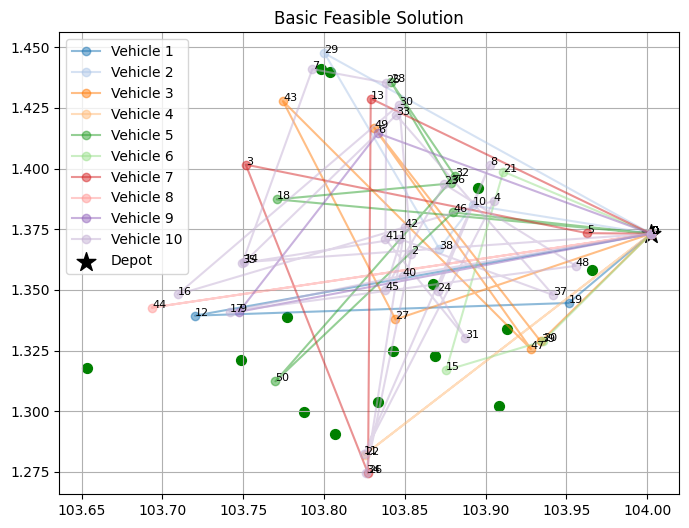

In [6]:
random.seed(5)

def generate_initial_solution():# -> list:
    """
    naive method - create BFS by randomly assigning customers to vehicles
    """
    nodes = list(range(1, 1 + NUM_CUSTOMERS))  # customer indices
    random.shuffle(nodes)
    split_indices = sorted(random.sample(range(1, len(nodes)), NUM_VEHICLES - 1))
    split = np.array_split(nodes, np.array(split_indices)) #creates uneven splits

    routes = []
    for chunk in split:
        if len(chunk) > 0:
            routes.append([0] + list(chunk) + [0])

    while len(routes) < NUM_VEHICLES:
        routes.append([0,0])
    
    return routes

colors = [plt.get_cmap("tab20")(i) for i in range(NUM_VEHICLES)]
current_solution = generate_initial_solution()
locations_e = np.array([[lat, lon] for (lat, lon) in locations])

plt.figure(figsize=(8, 6))
for i, route in enumerate(current_solution):
    
    pts = locations_e[route]
    plt.plot(pts[:, 0], pts[:, 1], color=colors[i], alpha=0.5, marker='o', label=f"Vehicle {i+1}")

    for idx in route:
        plt.text(locations_e[idx, 0], locations_e[idx, 1], str(idx), fontsize=8)

plt.scatter(*locations_e[0], c='black', s=200, marker='*', label='Depot')
for k in range(1+NUM_CUSTOMERS, n):
    plt.scatter(*locations_e[k], c='green', s=50, marker='o')

plt.title("Basic Feasible Solution")
plt.legend()
plt.grid(True)
plt.show()

## Simulated Annealing Algorithm

In [12]:
random.seed(5)
operators = [
    tweak_insert,
    swap_within_vehicle,
    swap_routes,
    swap_k_opt,
    add_charger_to_route,
    remove_charger_from_route
]

initial_solution = generate_initial_solution()
current_solution = initial_solution

current_cost, _ = calculate_total_cost(current_solution, locations)

best_cost = better_cost = total_distance(current_solution, locations)
best_solution = better_solution = current_solution
best_feasible_solution = None
best_feasible_cost = float('inf')

INIT_TEMP = 100000 # 10000 is too high so i slowed it down to by changing to 1000 to try
COOL_RATE = 0.995
curr_temp = INIT_TEMP
MAX_ITER = 100000

iterations = []
costs = []

true_it = 0

for it in trange(MAX_ITER):
    
    # a. Generate a neighbor by picking a random operator
    chosen_operator = random.choice(operators)
    candidate_solution = chosen_operator(current_solution) # The candidate can be infeasible

    # b. Calculate the cost of the candidate using the NEW penalty function
    candidate_cost, (dist, veh, batt_viol, time_viol) = calculate_total_cost(candidate_solution, locations)
    
    # c. Decide whether to accept the candidate solution
    delta = candidate_cost - current_cost
    
    # Acceptance criteria
    if delta < 0 or (curr_temp > 0 and random.random() < math.exp(-delta / curr_temp)):
        current_solution = candidate_solution
        current_cost = candidate_cost

    # d. Update the best-known solutions
    if current_cost < best_cost:
        best_solution = current_solution # This is the best solution found so far (could be infeasible)
        best_cost = current_cost

    # Also track the best FEASIBLE solution separately
    is_candidate_feasible = (batt_viol == 0 and time_viol == 0)
    if is_candidate_feasible and candidate_cost < best_feasible_cost:
        best_feasible_solution = candidate_solution
        best_feasible_cost = candidate_cost

    # e. Log progress and cool down temperature
    iterations.append(it)
    costs.append(current_cost) # Log the cost of the currently accepted solution
    curr_temp *= COOL_RATE
            
    if curr_temp < 1e-3:
        print("\nTemperature cooled down. Stopping early.")
        break

# After the loop, decide which solution to show.
# Prioritize the best feasible one if it was found.
if best_feasible_solution is not None:
    final_solution_to_display = best_feasible_solution
    final_cost_to_display, final_details = calculate_total_cost(final_solution_to_display, locations)
    print(f"\nBest FEASIBLE solution found with cost: {final_cost_to_display:.2f}")
    print(f"Details (Dist, Veh, BattViol, TimeViol): {final_details}")
else:
    # If no feasible solution was found, show the best infeasible one.
    # This tells you that your penalty weights or search time might be insufficient.
    final_solution_to_display = best_solution
    final_cost_to_display, final_details = calculate_total_cost(final_solution_to_display, locations)
    print(f"\nNo feasible solution found. Displaying best INFEASIBLE solution with cost: {final_cost_to_display:.2f}")
    print(f"Details (Dist, Veh, BattViol, TimeViol): {final_details}")

  4%|▎         | 3674/100000 [00:02<01:15, 1273.48it/s]
Temperature cooled down. Stopping early.

Best FEASIBLE solution found with cost: 3407.59
Details (Dist, Veh, BattViol, TimeViol): (407.5917747061936, 6, 0, 0)




--- Vehicle 1 ---
Route: 0 -> 12 -> 19 -> 0
Distance: 63.69 km
Violations (Battery, Time): (1.91, 0.00)

--- Vehicle 2 ---
Route: 0 -> 10 -> 38 -> 29 -> 0
Distance: 51.17 km
Violations (Battery, Time): (0.00, 0.00)

--- Vehicle 3 ---
Route: 0 -> 27 -> 43 -> 47 -> 49 -> 39 -> 0
Distance: 89.95 km
Violations (Battery, Time): (6.82, 0.00)

--- Vehicle 4 ---
Route: 0 -> 22 -> 0
Distance: 44.21 km
Violations (Battery, Time): (0.00, 0.00)

--- Vehicle 5 ---
Route: 0 -> 46 -> 50 -> 32 -> 28 -> 36 -> 18 -> 0
Distance: 93.60 km
Violations (Battery, Time): (7.50, 0.00)

--- Vehicle 6 ---
Route: 0 -> 21 -> 15 -> 20 -> 0
Distance: 36.12 km
Violations (Battery, Time): (0.00, 0.00)

--- Vehicle 7 ---
Route: 0 -> 5 -> 3 -> 26 -> 13 -> 0
Distance: 81.84 km
Violations (Battery, Time): (5.30, 0.00)

--- Vehicle 8 ---
Route: 0 -> 44 -> 0
Distance: 68.87 km
Violations (Battery, Time): (2.88, 0.00)

--- Vehicle 9 ---
Route: 0 -> 6 -> 9 -> 0
Distance: 60.38 km
Violations (Battery, Time): (1.29, 0.00)

--- 

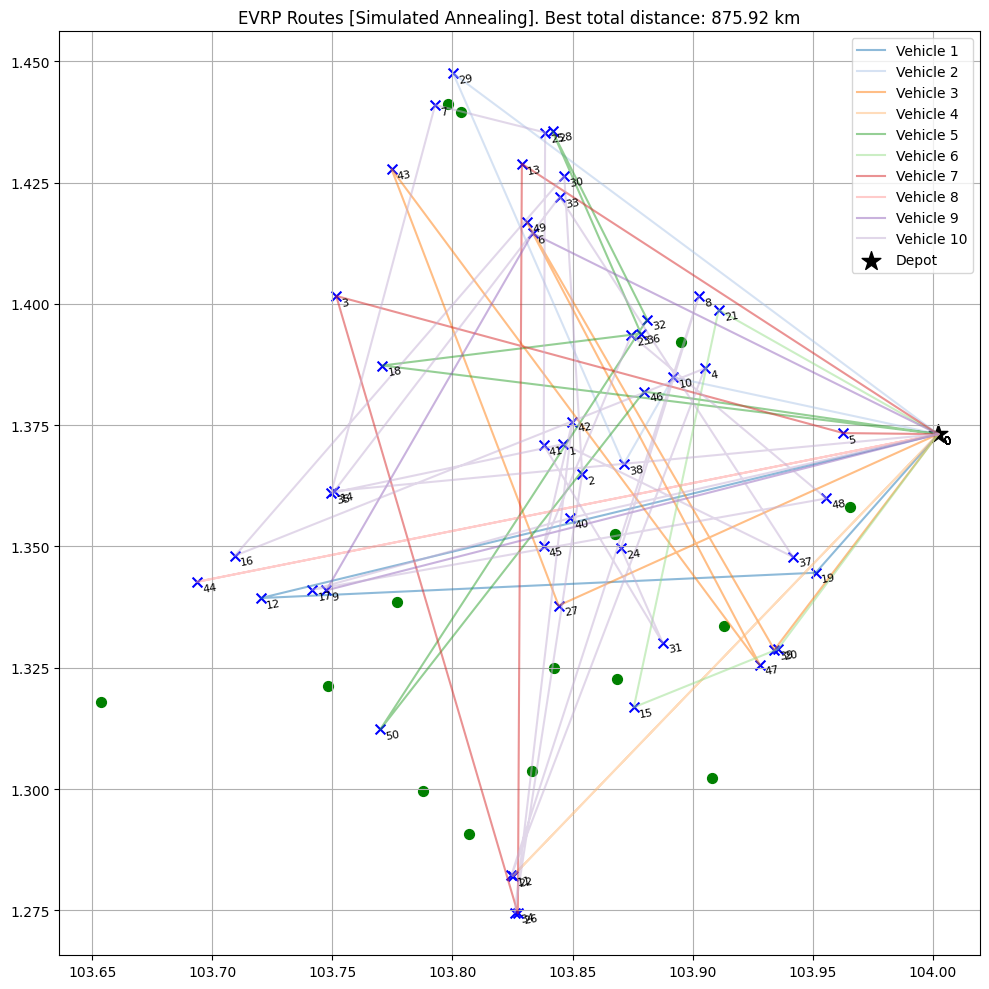

In [8]:
# Plot Optimal Routes
for v, route in enumerate(best_solution):
    if len(route) <= 2: continue # Skip empty routes
    
    # Recalculate route stats for clean display
    batt_viol, time_viol = calculate_route_violations(route, locations)
    dist = total_distance([route], locations) # Assuming total_distance can take a list of routes
    
    print(f"\n--- Vehicle {v+1} ---")
    print(f"Route: {' -> '.join(map(str, route))}")
    print(f"Distance: {dist:.2f} km")
    print(f"Violations (Battery, Time): ({batt_viol:.2f}, {time_viol:.2f})")


# conversion_to_allow_indexing
locations_e = np.array([[lon, lat] for (lon, lat) in locations])

plt.figure(figsize=(10, 10))
for i, route in enumerate(best_solution):
    pts = locations_e[route]
    plt.plot(pts[:, 0], pts[:, 1], color=colors[i], alpha=0.5, label=f"Vehicle {i+1}")

    for idx in route:
        # offset slightly
        plt.text(locations_e[idx, 0] + 0.002, locations_e[idx, 1] - 0.002, str(idx), fontsize=8, rotation=10.)
        
plt.scatter(*locations_e[0], c='black', s=200, marker='*', label='Depot')
for k in range(1+NUM_CUSTOMERS, n):
    plt.scatter(*locations_e[k], c='green', s=50, marker='o')
for k in range(1, NUM_CUSTOMERS+1):
    plt.scatter(*locations_e[k], c='blue', s=50, marker='x')

plt.title(f"EVRP Routes [Simulated Annealing]. Best total distance: {best_cost:.2f} km")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


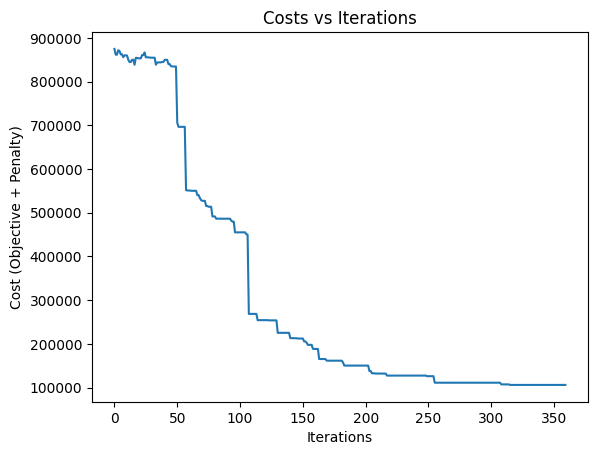

In [9]:
plt.plot(iterations, costs)
plt.title("Costs vs Iterations")
plt.xlabel('Iterations')
plt.ylabel("Cost (Objective + Penalty)")
plt.show()